# Reduce Predictor Count of Breast Cancer Detection Model

**Code authored by**: Shawhin Talebi <br>
**Article link**: https://medium.com/@shawhin/2-next-level-uses-of-decision-trees-80f60b3c61d9 <br>

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer # toy dataset (sorry)

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Data prep

In [2]:
df = load_breast_cancer(as_frame = True)['frame']

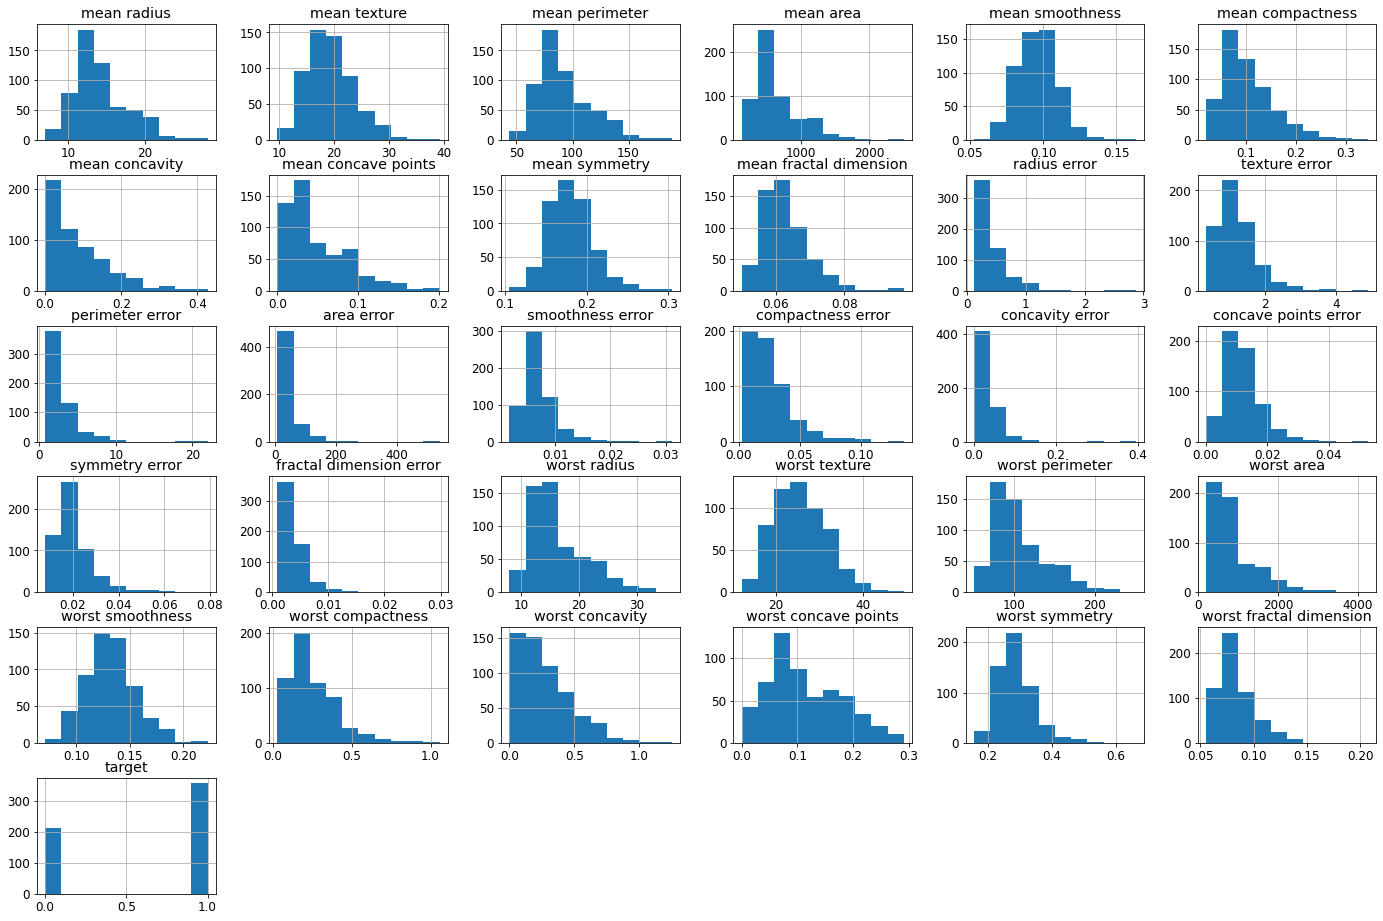

In [3]:
plt.rcParams.update({'font.size': 12})

# plot variable histograms
df.hist(figsize=(24,16))
plt.savefig('visuals/use-1_raw_histograms.png',facecolor='white',bbox_inches="tight")

##### Define predictors and target

In [4]:
# define predictor and target variable names
X_var_names = df.columns[:df.shape[1]-1]
y_var_name = df.columns[df.shape[1]-1]

# create predictor and target arrays
X = df[X_var_names]
y = df[y_var_name]

# transform y such that 1=>malignant and 0=>benign
y = -1*y + 1

#### Balance data using SMOTE

In [5]:
# oversample minority class using smote
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X, y)

# create train and test datasets using balanced
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

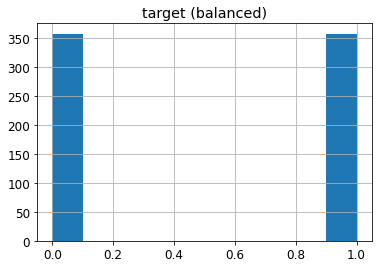

In [6]:
y_resampled.hist(figsize=(6,4))
plt.title('target (balanced)')
plt.savefig('visuals/use-1_balanced_target_histogram.png',facecolor='white',bbox_inches="tight")

### Modeling

##### Random Forest Model

In [7]:
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)

In [8]:
rf_auc_val = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
rf_auc_val

0.995266272189349

In [9]:
feature_importances = pd.Series(clf.feature_importances_, index=X_var_names)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print(feature_importances_sorted)

worst perimeter            0.162599
mean concave points        0.130250
worst concave points       0.114780
worst radius               0.090778
mean perimeter             0.070582
worst area                 0.070437
mean concavity             0.069336
mean area                  0.048827
worst concavity            0.028572
area error                 0.025876
mean radius                0.025522
radius error               0.022607
worst texture              0.019605
mean texture               0.016867
worst smoothness           0.014385
perimeter error            0.012798
worst compactness          0.011256
worst symmetry             0.010062
mean compactness           0.007886
worst fractal dimension    0.007071
mean smoothness            0.006960
fractal dimension error    0.005246
concavity error            0.005028
symmetry error             0.004704
concave points error       0.003798
mean fractal dimension     0.003248
mean symmetry              0.003213
texture error              0

##### Additive Logistic Regression models

In [10]:
# intialize lists
base_clf_list = []
train_auc_list = []
test_auc_list = []

i=0
for i in range(len(feature_importances_sorted)):

    feature_names = list(feature_importances_sorted.index[:i+1])
    base_clf = LogisticRegression(random_state=0, solver='newton-cg').fit(X_train[feature_names], y_train)

    base_clf_list.append(base_clf)
    train_auc_list.append(roc_auc_score(y_train, base_clf.predict_proba(X_train[feature_names])[:,1]))
    test_auc_list.append(roc_auc_score(y_test, base_clf.predict_proba(X_test[feature_names])[:,1]))

##### Plot performance vs variable count

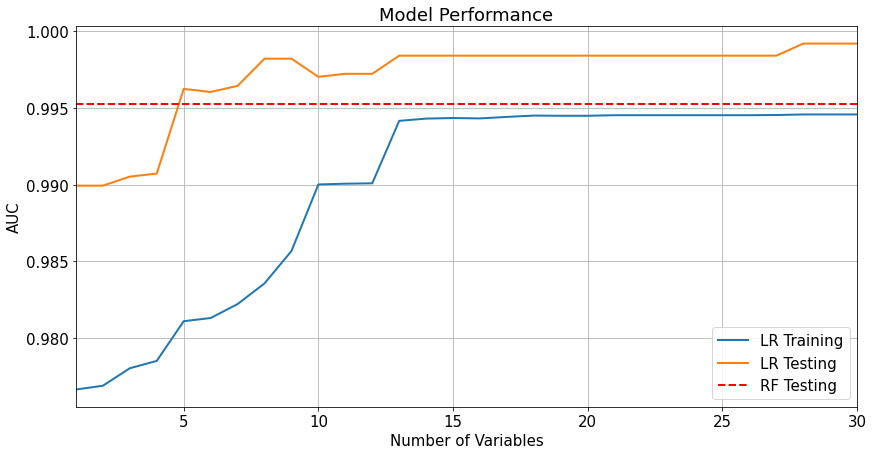

In [11]:
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 15})

plt.plot(np.linspace(1,30,30), train_auc_list, linewidth=2)
plt.plot(np.linspace(1,30,30), test_auc_list, linewidth=2)
plt.plot([1,30], [rf_auc_val, rf_auc_val], 'r--', linewidth=2)
plt.grid()
plt.legend(["LR Training", "LR Testing", "RF Testing"])
plt.title("Model Performance")
plt.xlabel("Number of Variables")
plt.ylabel("AUC")
plt.xlim([1, 30])
plt.savefig('visuals/use-1_performance-vs-numVars.png',facecolor='white',bbox_inches="tight")

##### Plot Logistic Regression model coefficients

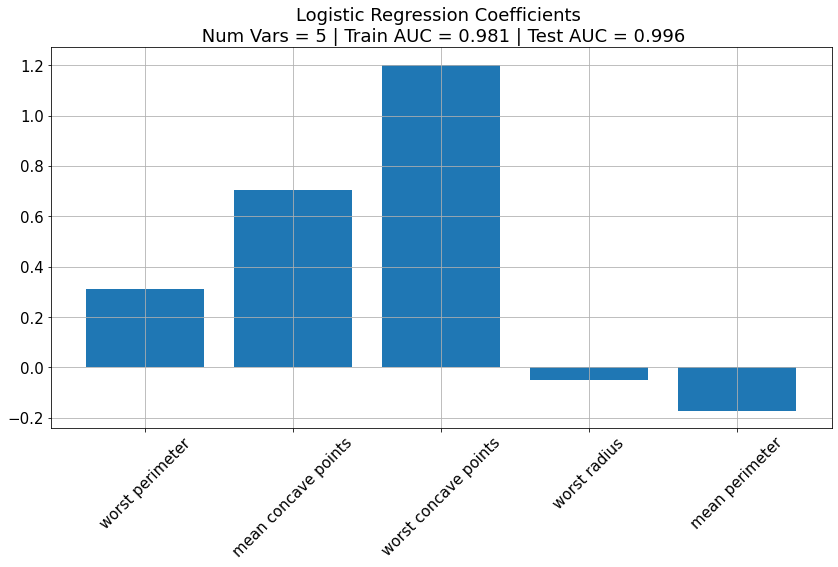

In [12]:
num_vars = 5

plt.figure(figsize=(14, 7))
plt.bar(np.linspace(1,num_vars,num_vars), base_clf_list[num_vars-1].coef_[0])
plt.grid()
plt.xticks(np.linspace(1,num_vars,num_vars), list(feature_importances_sorted.index[:num_vars]), rotation=45)
plt.title( "Logistic Regression Coefficients \n Num Vars = " + str(num_vars) + " | Train AUC = " + str(np.round(train_auc_list[num_vars-1],3)) + " | Test AUC = " + str(np.round(test_auc_list[num_vars-1],3)))
plt.savefig('visuals/use-1_LR_coefficents_numVars='+str(num_vars)+'.png',facecolor='white',bbox_inches="tight")
plt.show()